# Using Custom Transformers in Pyreal

In this tutorial, we will be using Pyreal to investigate the California Housing Dataset. 

In order to generate useful explanations, we will making a few custom transformers, with functionality specific to this use-case.

## Data Loading

This dataset includes 9 predictor variables, and one target variable. Each row in the dataset refers to a block of houses in California. The target variable is the median house value in this block.

**Run the cell below to load in the California Housing Dataset.**

In [1]:
import matplotlib.pyplot as plt
from urllib.parse import urljoin
import pandas as pd

AWS_BASE_URL = 'https://pyreal-data.s3.amazonaws.com/'
data_url = urljoin(AWS_BASE_URL, "usability_study/california.csv")
data = pd.read_csv(data_url)

city_url = urljoin(AWS_BASE_URL, "usability_study/cal_cities_lat_long.csv")
cities = pd.read_csv(city_url)

data = data[data["median_house_value"] < 500000]

data = data.sample(5000, random_state=100)  # we will work with a truncated dataset to avoid memory crashes

X = data.drop("median_house_value", axis=1)
y = data["median_house_value"]

data.sample(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_house_value
18190,-122.01,37.37,11,2559,694.0,1309,668,4.1847,<1H OCEAN,167300
4438,-118.20,34.08,41,1807,429.0,1699,424,2.2222,<1H OCEAN,126000
14054,-117.13,32.75,28,2279,671.0,1166,623,1.9500,NEAR OCEAN,150000
1499,-122.04,37.95,33,1653,334.0,814,328,3.1406,NEAR BAY,163100
14083,-117.11,32.77,52,1506,233.0,478,240,4.3875,NEAR OCEAN,300000
910,-122.00,37.55,27,6103,1249.0,3026,1134,4.1591,<1H OCEAN,332400
8709,-118.35,33.85,34,1770,291.0,916,289,5.0000,<1H OCEAN,354200
14219,-117.05,32.67,16,2168,343.0,1589,338,5.4863,NEAR OCEAN,153800
15388,-117.05,33.26,14,3103,569.0,1704,539,3.7644,<1H OCEAN,264700
17513,-121.92,37.33,52,2009,338.0,841,338,5.5259,<1H OCEAN,295800


We will be working with a pretrained model to predict the median house values for each block. 

**Run the code below to load in the model.** 

In [2]:
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import requests

model_url = urljoin(AWS_BASE_URL, "usability_study/model.model")
r = requests.get(model_url, allow_redirects=True)
open('model.model', 'wb').write(r.content)

model = lightgbm.Booster(model_file='model.model')

ModuleNotFoundError: No module named 'lightgbm'

# Model Performance

⭐**Please read the following description of the model's performance on a held-out test set:**

- Mean predicted price (the average value predicted by the model for `median_house_value`: **$199,622**

- Mean real price (the average true value for `median_house_value`): **$198,990**

- Mean-absolute-error (the average, absolute difference between the real value and the predicted value for `median_house_value`): **$29,823**

- r^2 score (the r^2 value usually ranges from 0 to 1, with a value closer to 1 *generally* meaning the model performs better): **0.80**

The plot below shows the true value versus predicted value for a selection of blocks from the held-out test set. 

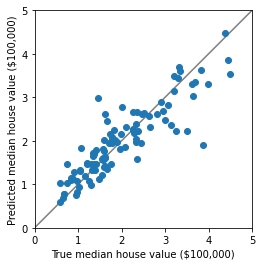

⭐**Now, please switch to the Qualtrics survey tab (the tab you started this user study on), press the "next" button, and answer the questions listed. Keep this colab notebook open.**

# Defining Transformers

As you saw in the tutorial, Pyreal generates ML explanations using Explainer objects, which take in data Transformers through their `transformer` parameter. These Transformers take in three flags in their initialization, two of which we will use in this user study:

- Transformers with a `model=True` flag take data from the original feature space (as we loaded in above) to the feature space used by the model.
- Transformers with an `interpret=True` flag take data from the original feature space to a feature space more readable or interpretable by humans. 

All transformers you will need can be found in the Pyreal `transformer` package, or defined in the next two code cells. The useful transformer classes are imported in the cells below.

## Model Transformers

The explanation algorithms you will be using expect the data to be in the model-ready feature space. The model requires data that has the following transformations:
1. All data should be imputed, using the mean value for numeric features and the mode for categorical features. This can be done using a [MultiTypeImputer](https://sibyl-ml.dev/pyreal/api_reference/api/pyreal.transformers.MultiTypeImputer.html#pyreal.transformers.MultiTypeImputer)
2. The ``ocean_proximity`` feature should be one-hot encoded. This can be done using a [OneHotEncoder](https://sibyl-ml.dev/pyreal/api_reference/api/pyreal.transformers.OneHotEncoder.html#pyreal.transformers.OneHotEncoder)
3. Two new features should be added: the average number of rooms per household (``average_rooms``) and the average number of bedrooms per household (``average_bedrooms``). Note that these features should be included in the final explanation displayed, so this transformer should be flagged `interpret=True`.

We've added one Transformer class below that may be helpful. All others that you will need can be found in the pyreal ``transformer`` module.

⭐**Run the cell below to define the PerHouseholdAverager, which is a transformer that can be used to add the two features introduced in item 3 above.** 


In [ ]:
from pyreal.transformers import OneHotEncoder, MultiTypeImputer, Transformer, fit_transformers, run_transformers
from pyreal.types.explanations.dataframe import AdditiveFeatureContributionExplanation

class PerHouseholdAverager(Transformer):
  def __init__(self, columns, **kwargs):
    # columns: the columns to average. Must be list of strings (column names)
    self.columns = columns
    super().__init__(**kwargs)

  def data_transform(self, x):
    # Transform the data by adding a new column from total_[column] called 
    #   average_[column]. This feature represents the average value of 
    #   [column] per household. 
    for column in self.columns:
      name = column.replace("total", "average")
      x[name] = x[column] / x["households"]
    return x

  def inverse_transform_explanation(self, explanation):
    # In this case, we would still like to see the average value feature
    #   in the explanation, as it may be more meaningful and interesting
    #   than the total number. Therefore, we will not modify the explanation
    #   when transforming it back into the original feature space
    return explanation

##  Interpretable Transformers

You may prefer the explanations given in a more human-readable format. Here, we provide a few other transformers that may make explanations easier to use. Keep in mind the model will **not** accept data that has had these transformations, and therefore they should be flagged `model=False`. Rather, set `interpret=True` to mark these as transformers that *improve interpretability*

Additionally, remember that we want to the final explanation to include the `average_rooms` and `average_bedrooms` features, so the `PerHouseholdAverager` transformer should also be flagged `interpret=True`

⭐**Run the cell below to define two more transformers, which scale the units of features to their actual value, and convert lat/long values to predicted cities.** 

In [ ]:
class UnitScaler(Transformer):
  def __init__(self, column, scale, **kwargs):
    # column: string, column to scale
    # scale: value to multiply column by
    self.column = column
    self.scale = scale
    super().__init__(**kwargs)

  def data_transform(self, x):
    # Scales the data to a more human readable scale
    x[self.column] = x[self.column] * self.scale
    return x

  def transform_explanation(self, explanation):
    # This transform will not modify the explanation, so we return it as is
    return explanation

  def inverse_transform_explanation(self, explanation):
    # This transform will not modify the explanation, so we return it as is
    return explanation

class CityConverter(Transformer):
  def __init__(self, **kwargs):
    self.cities = cities
    super().__init__(**kwargs)

  def data_transform(self, x):
    # Converts latitude/longitude coordinates to closest city name. Note that 
    #    we are using a very rough estimate here, assuming constant size. 
    #    For the sake of answering questions, please assume this works 
    #    sufficiently well
    flag = False
    if isinstance(x, pd.Series):
      x = x.to_frame().T
      flag = True
    for index, row in self.cities.iterrows():
      lat = row["Latitude"]
      lon = row["Longitude"]
      x.loc[(x["latitude"] > lat-0.1) & (x["latitude"] < lat+0.1) & (x["longitude"] > lon-0.1) & (x["longitude"] < lon+0.1), "city"] = row["Name"]
    x = x.drop("latitude", axis=1)
    x= x.drop("longitude", axis=1)
    if flag:
      x = x.squeeze(axis=0)
    return x

  def transform_explanation_additive_contributions(self, explanation):
    # In the case of additive contributions, we can combine the latitude and 
    #    longitude explanation contributions by adding to get the city 
    #    contribution
    explanation = explanation.get()
    explanation["city"] = explanation["longitude"] + explanation["latitude"]
    explanation = explanation.drop("longitude", axis=1)
    explanation = explanation.drop("latitude", axis=1)
    return AdditiveFeatureContributionExplanation(explanation)

# Generating Global Explanations

You can now start using Pyreal Explainers to investigate the model. Remember to take a look at the links at the top of this page as needed.

We will begin by generating a *global* explanation, or an explanation of how the model makes predictions in general.

⭐**In the next cell, initialize, fit, and call the produce function on a `GlobalFeatureImportance` Explainer.**

⭐**Remember, you will need to begin by initalizing and fitting the required transformers. Revisit the cells above for details on the transformers you will need and their flags. You can use the `fit_transformers` function to quickly fit them.** 

In [ ]:
from pyreal.explainers import GlobalFeatureImportance
from pyreal.transformers import fit_transformers
from pyreal.utils import visualize

# Step one: Initialize and fit transformers using fit_transformers
# ---- Your code here ----

# Step two: Initialize and fit the explainer
# ---- Your code here ----

# Step three: Generate and visualize the explanation
# ---- Your code here ----

⭐**Now, please press the "next" button on the Qualtrics survey tab and answer the next set of questions, referencing this tab as needed.** ⭐




# Generating Local Explanations

⭐ **Now, please consider the `sample_block` listed below, which refers to a hypothetical block of houses that might exist in California. Run the code block.**



In [ ]:
sample_block = pd.Series({
  "longitude": -122.23,
  "latitude": 37.88,
  "housing_median_age": 16,
  "total_rooms": 672,
  "total_bedrooms": 230,
  "population": 220,
  "households": 52,
  "median_income":  5.3252,
  "ocean_proximity": "NEAR BAY" 
})


We will now generate a *local* explanation, or an explanation of why the model makes the prediction it does for the specific `sample_block` above.

⭐**In the next cell, initialize, fit, and call the produce function on a `LocalFeatureContribution` Explainer. Generate an explanation for the prediction of the `sample_block` above.**

⭐**You can likely reuse the already-fit transformers from the previous section. If you would like to use any more, remember to fit them before using.**

In [ ]:
from pyreal.explainers import LocalFeatureContribution
from pyreal.transformers import fit_transformers
from pyreal.utils import visualize

# Step one: Initialize and fit the explainer
# ---- Your code here ----

# Step two: Generate and visualize the explanation
# ---- Your code here ----

⭐**Now, please press the "next" button on the Qualtrics survey tab and answer the next set of questions, referencing this tab as needed.** ⭐


# Downloading This Notebook

⭐**Once you have finished answering all questions, save and download this notebook to a location of your choosing using `File` &#8594; `Download` &#8594; `Download .ipynb`, in the upper left toolbar of this page. You will need to upload it shortly to the Qualtrics survey.**

⭐**Please return to the Qualtrics survey now and press next, then follow instructions to upload this notebook, and then answer final reflection questions.** 